## ICU Stay Duration Prediction with LSTM Recurrent Neural Networks in Python with Keras


This is kind of time series forcasting.

Problem description :  Build analgorithm that can help the doctors at the IC decide who can be discharged using the signal data of the patient. This algorithm should be able to predict which patients have a high risk of being readmitted if they where to be discharged.

### Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42

### Check reproducibility

In [2]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Read data from files 

In [3]:
input_age = 'age.csv'
input_admission = 'admission.csv'
input_signal = 'signal.csv'
delimiter = ';'
data_age = pd.read_csv(input_age,sep = delimiter)
data_admission = pd.read_csv(input_admission ,sep = delimiter)
data_signal = pd.read_csv(input_signal,sep = delimiter)

### Add column that show how long patient stay at ICU

In [4]:
from datetime import datetime, date, timedelta
data_admission['duration']= [int(i.days) for i in 
                             (pd.to_datetime(data_admission['date_discharge'])- pd.to_datetime(data_admission['date_admission']))]

### Merge all table of data

In [5]:
data_all = [data_age,data_admission,data_signal]

In [6]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],
                                            how='left'), data_all)

### extract features from signal table 

In [7]:
df_groupby =df_merged.pivot_table('value', ['pat_id', 'age','date_admission','date_discharge','duration','day','hour'],'parameter')

In [8]:
df_groupby.reset_index( drop=False, inplace=True )

In [9]:
df_groupby.head()

parameter,pat_id,age,date_admission,date_discharge,duration,day,hour,blood_pressure,respiration_rate,temperature
0,0,35.0,2016-01-05,2016-01-07,2.0,2016-01-05,23.0,104.543181,NaN,NaN
1,0,35.0,2016-01-05,2016-01-07,2.0,2016-01-06,0.0,110.542544,NaN,NaN
2,0,35.0,2016-01-05,2016-01-07,2.0,2016-01-06,1.0,133.832002,NaN,NaN
3,0,35.0,2016-01-05,2016-01-07,2.0,2016-01-06,2.0,133.067666,NaN,NaN
4,0,35.0,2016-01-05,2016-01-07,2.0,2016-01-06,3.0,134.566003,NaN,NaN


In [10]:
df_groupby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71969 entries, 0 to 71968
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pat_id            71969 non-null  int64  
 1   age               71969 non-null  float64
 2   date_admission    71969 non-null  object 
 3   date_discharge    71969 non-null  object 
 4   duration          71969 non-null  float64
 5   day               71969 non-null  object 
 6   hour              71969 non-null  float64
 7   blood_pressure    68724 non-null  float64
 8   respiration_rate  32749 non-null  float64
 9   temperature       7579 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 5.5+ MB


In [11]:
df_groupby.describe()

parameter,pat_id,age,duration,hour,blood_pressure,respiration_rate,temperature
count,71969.000000,71969.000000,71969.000000,71969.000000,68724.000000,32749.000000,7579.000000
mean,872.312635,59.017702,2.970279,11.229071,126.221852,8.326627,37.386484
std,441.455351,16.631253,1.912337,6.999505,27.264761,5.409157,0.938477
min,0.000000,12.000000,0.000000,0.000000,20.000005,-0.010000,31.692309
25%,513.000000,50.000000,1.000000,5.000000,108.270469,4.010000,36.923079
50%,908.000000,63.000000,2.000000,11.000000,122.299169,7.990000,37.430768
75%,1259.000000,71.000000,4.000000,17.000000,139.666004,10.010000,37.948717
max,1568.000000,91.000000,7.000000,23.000000,592.000007,149.990000,40.923077


### Sort data by date of admission to have a time series of data

In [12]:
df_ts = df_groupby.sort_values(['date_admission', 'day'], ascending=[True, True])

In [13]:
df_ts.shape

(71969, 10)

In [14]:
df_ts['day'] = pd.to_datetime(df_ts['day'])
df_ts['day_w'] = df_ts['day'].map(lambda x: x.day)
df_ts['month'] = df_ts['day'].map(lambda x: x.month)
df_ts['year'] = df_ts['day'].map(lambda x: x.year)

####  There are some outliers in blood presure. It seems they are far from actual values. 

<AxesSubplot:xlabel='pat_id', ylabel='blood_pressure'>

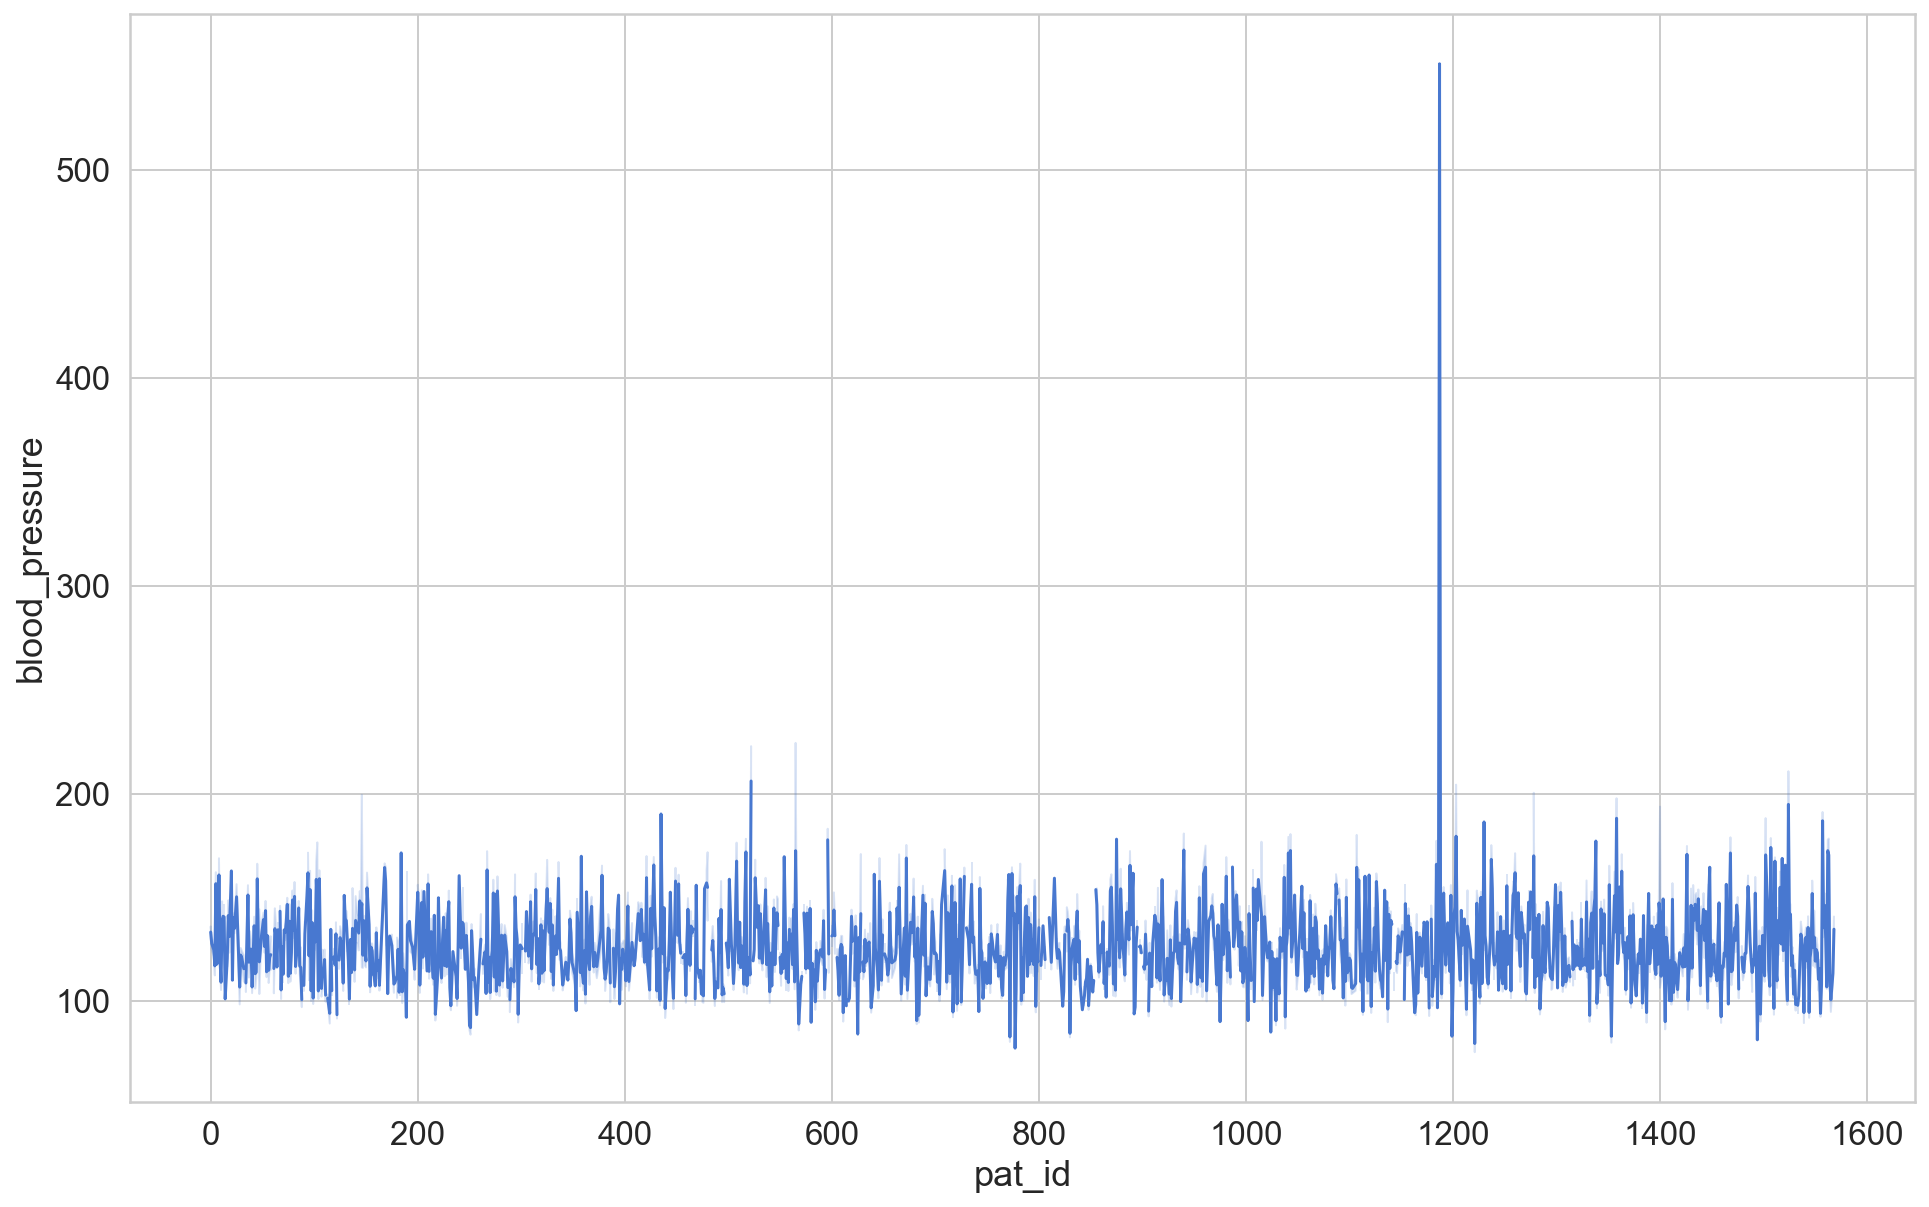

In [15]:
sns.lineplot(x='pat_id',y='blood_pressure', data=df_ts)

<AxesSubplot:xlabel='pat_id', ylabel='respiration_rate'>

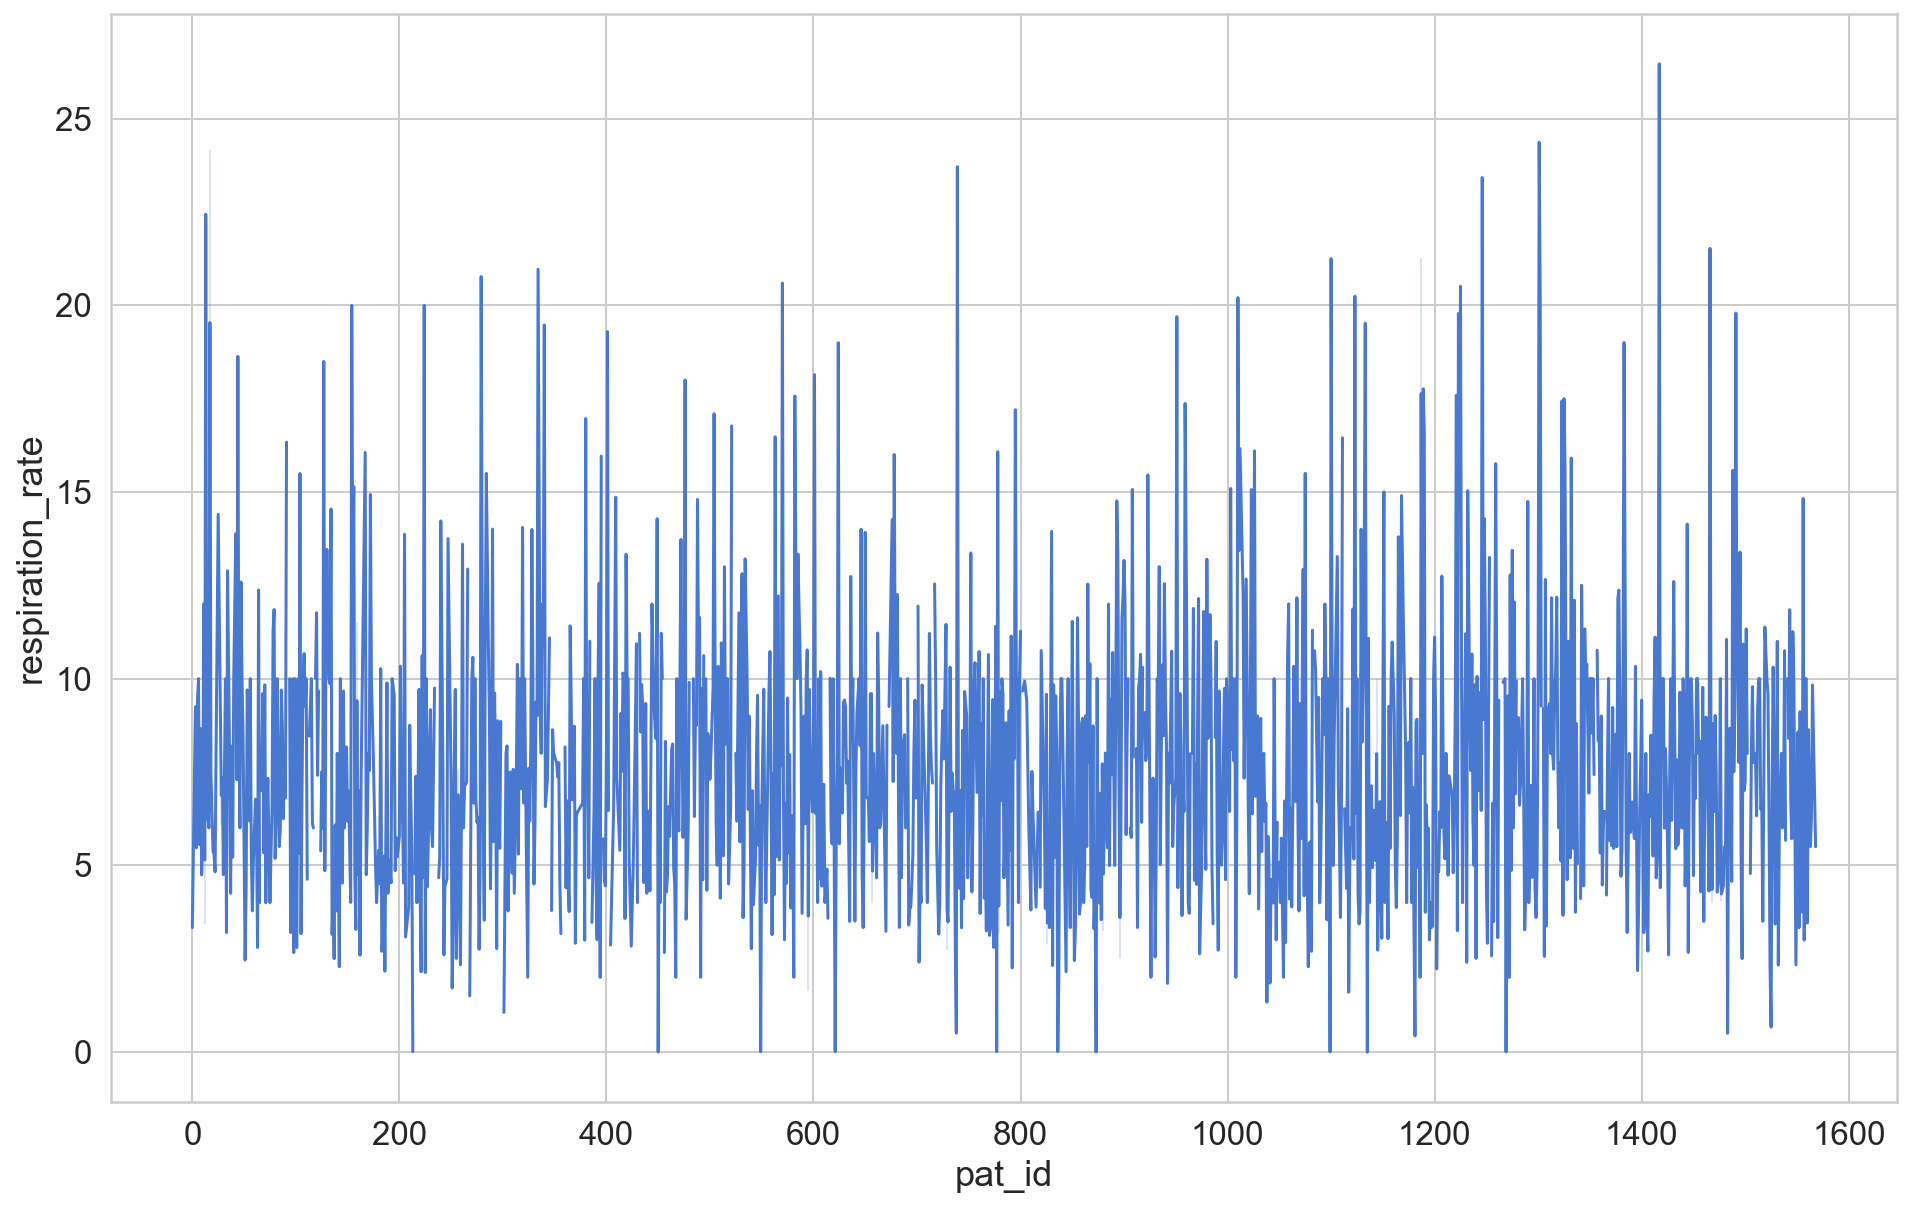

In [16]:
sns.lineplot(x='pat_id',y='respiration_rate', data=df_ts)

<AxesSubplot:xlabel='pat_id', ylabel='temperature'>

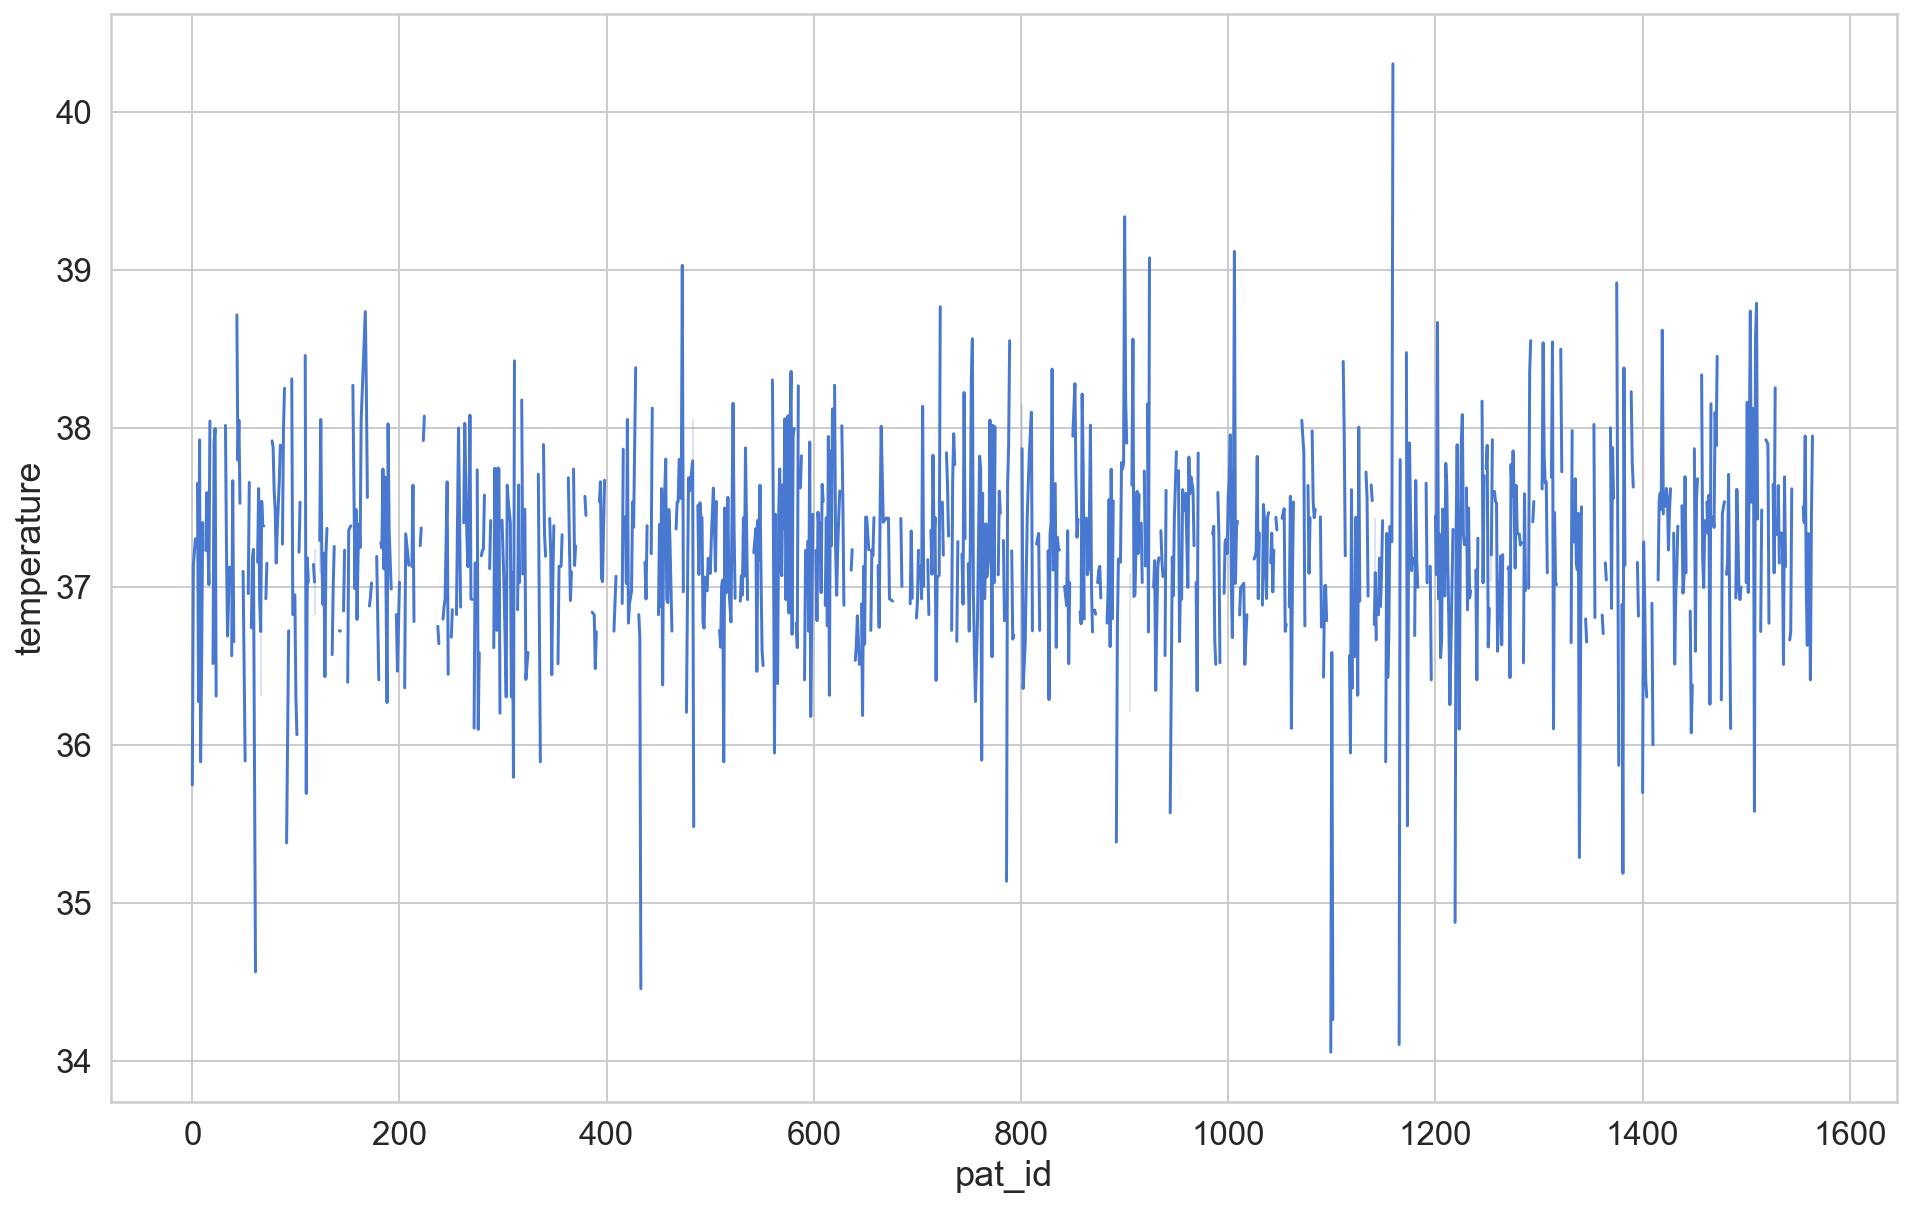

In [17]:
sns.lineplot(x='pat_id',y='temperature', data=df_ts)

In [18]:
## remove outliers and fill nan 
blood_pres_treshold = 250
df_ts = df_ts[df_ts['blood_pressure'] <= blood_pres_treshold]
df_ts['respiration_rate'].fillna(df_ts['respiration_rate'].mean(),inplace=True)
df_ts['temperature'].fillna(df_ts['temperature'].mean(),inplace=True)

In [19]:
df_ts.shape

(68560, 13)

#### Check all data using visualization

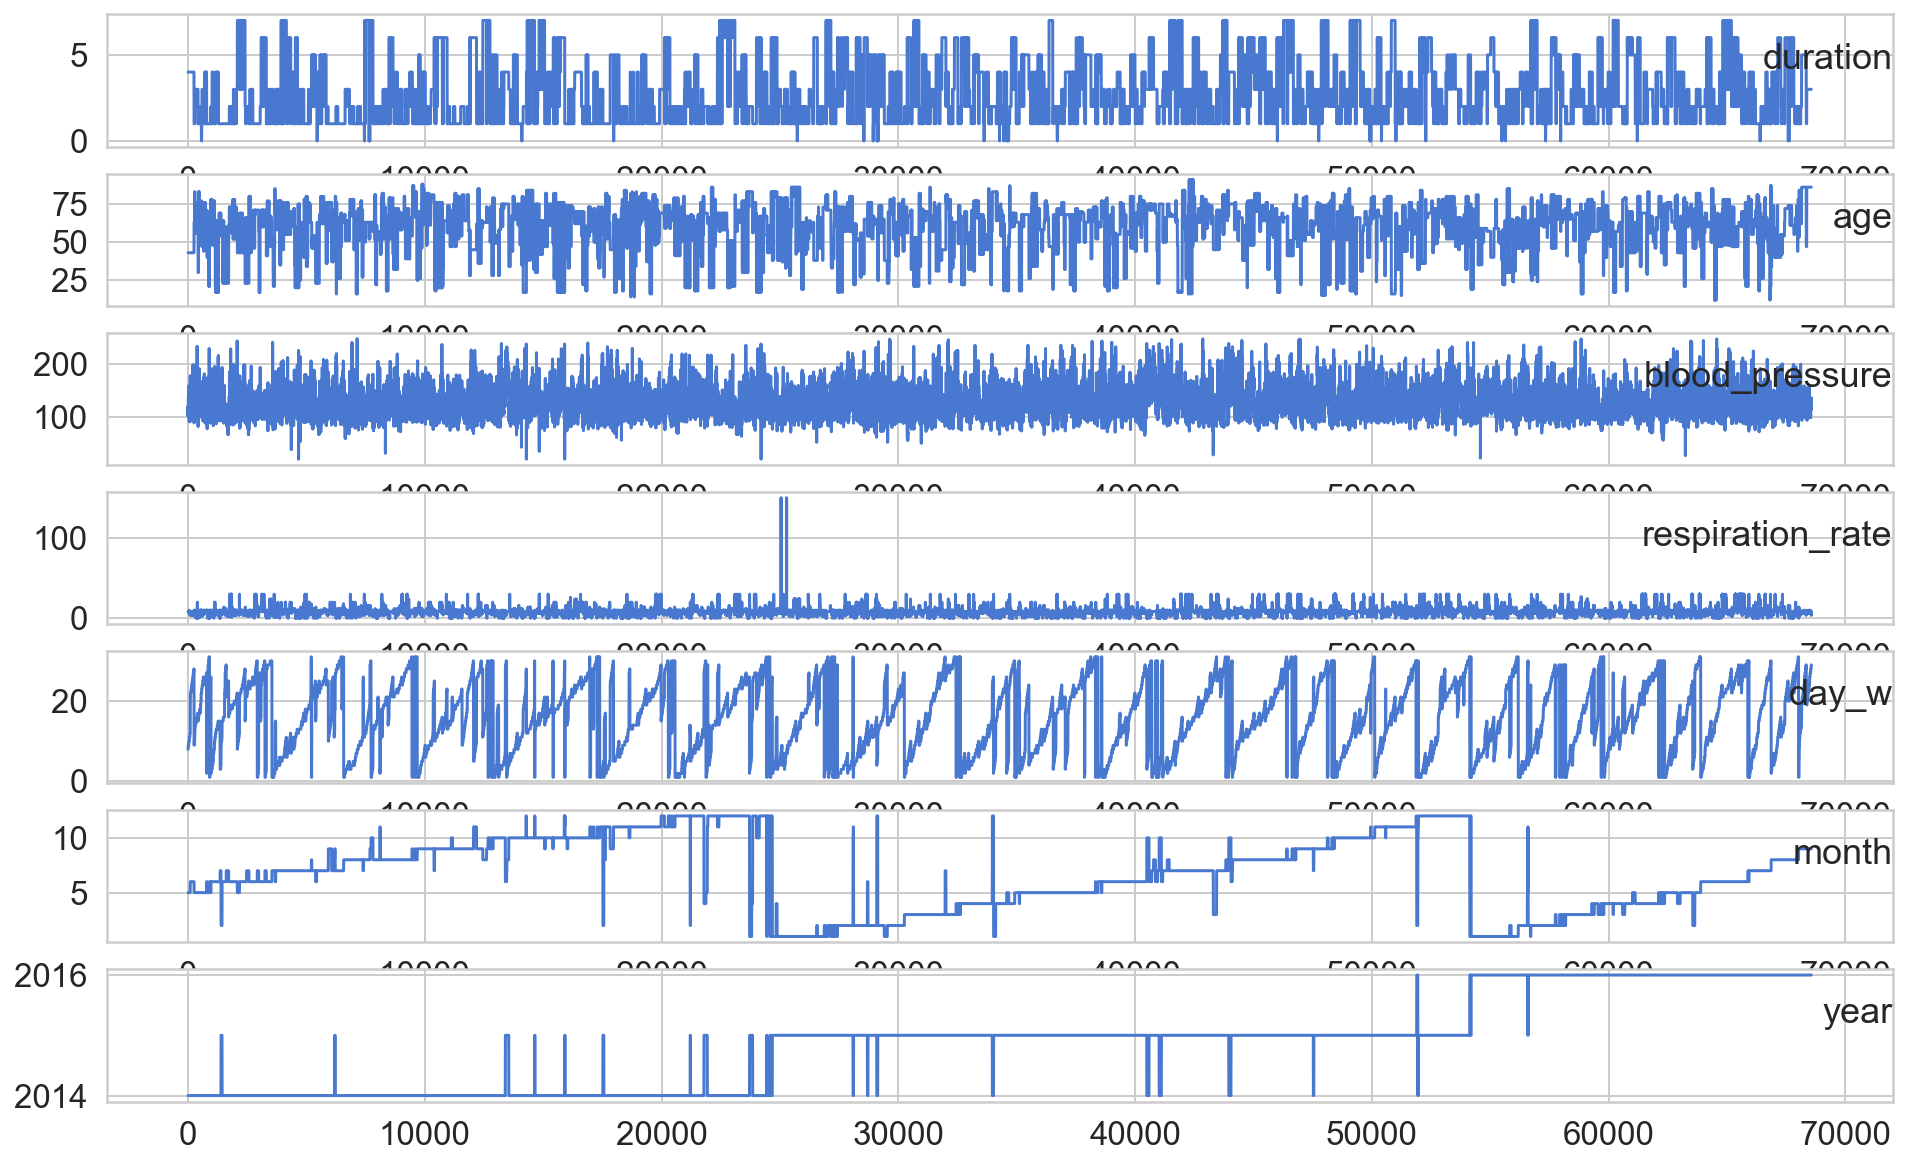

In [20]:
dataset = df_ts[['duration','age','blood_pressure','respiration_rate','temperature','day_w','month','year']]
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [21]:
# split train and test data , we use last 10% of the data as test
train_percentage = 0.9
train_size = int(len(dataset) * train_percentage)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(dataset)]
print(len(train), len(test))

61704 6856


### Normalization of data

LSTMs are sensitive to the scale of the input data. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [22]:
from sklearn.preprocessing import MinMaxScaler


In [23]:
### features columns 
f_columns = ['age','blood_pressure','respiration_rate','temperature','day_w','month','year']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

/Users/elham/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/elham/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [24]:
d_transformer = MinMaxScaler(feature_range=(0, 1))
d_transformer = d_transformer.fit(train[['duration']])
train['duration'] = d_transformer.transform(train[['duration']])
test['duration'] = d_transformer.transform(test[['duration']])

<ipython-input-24-4ef481fa0989>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['duration'] = d_transformer.transform(train[['duration']])
<ipython-input-24-4ef481fa0989>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['duration'] = d_transformer.transform(test[['duration']])


In [25]:
test.head()

parameter,duration,age,blood_pressure,respiration_rate,temperature,day_w,month,year
57415,0.428571,0.896104,0.405429,0.056235,0.610392,0.833333,0.272727,1.0
57416,0.428571,0.896104,0.414480,0.066667,0.610392,0.833333,0.272727,1.0
57417,0.428571,0.896104,0.403973,0.056235,0.610392,0.833333,0.272727,1.0
57418,0.428571,0.896104,0.427040,0.066667,0.610392,0.833333,0.272727,1.0
57419,0.428571,0.896104,0.444858,0.056235,0.610392,0.833333,0.272727,1.0


convert an array of values into a dataset matrix

In [26]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [27]:
#Each sequence is going to contain 10 data points from the history:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.duration, time_steps)
X_test, y_test = create_dataset(test, test.duration, time_steps)


In [28]:
## check Dimension of train and test 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(61694, 10, 8) (61694,)
(6846, 10, 8) (6846,)


In [29]:
X_test[0][0]

array([0.42857143, 0.8961039 , 0.40542936, 0.05623459, 0.61039199,
       0.83333333, 0.27272727, 1.        ])

## Create and fit the LSTM network

In [30]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history


Epoch 1/50
857/857 - 10s - loss: 0.0598 - val_loss: 0.0495
Epoch 2/50
857/857 - 8s - loss: 0.0333 - val_loss: 0.0313
Epoch 3/50
857/857 - 8s - loss: 0.0222 - val_loss: 0.0210
Epoch 4/50
857/857 - 7s - loss: 0.0180 - val_loss: 0.0164
Epoch 5/50
857/857 - 8s - loss: 0.0169 - val_loss: 0.0240
Epoch 6/50
857/857 - 8s - loss: 0.0172 - val_loss: 0.0228
Epoch 7/50
857/857 - 8s - loss: 0.0163 - val_loss: 0.0118
Epoch 8/50
857/857 - 8s - loss: 0.0152 - val_loss: 0.0150
Epoch 9/50
857/857 - 7s - loss: 0.0159 - val_loss: 0.0211
Epoch 10/50
857/857 - 7s - loss: 0.0154 - val_loss: 0.0265
Epoch 11/50
857/857 - 8s - loss: 0.0150 - val_loss: 0.0118
Epoch 12/50
857/857 - 8s - loss: 0.0165 - val_loss: 0.0153
Epoch 13/50
857/857 - 9s - loss: 0.0159 - val_loss: 0.0221
Epoch 14/50
857/857 - 10s - loss: 0.0157 - val_loss: 0.0168
Epoch 15/50
857/857 - 9s - loss: 0.0143 - val_loss: 0.0131
Epoch 16/50
857/857 - 8s - loss: 0.0156 - val_loss: 0.0179
Epoch 17/50
857/857 - 7s - loss: 0.0150 - val_loss: 0.0113
Epoc

## Model Evaluation

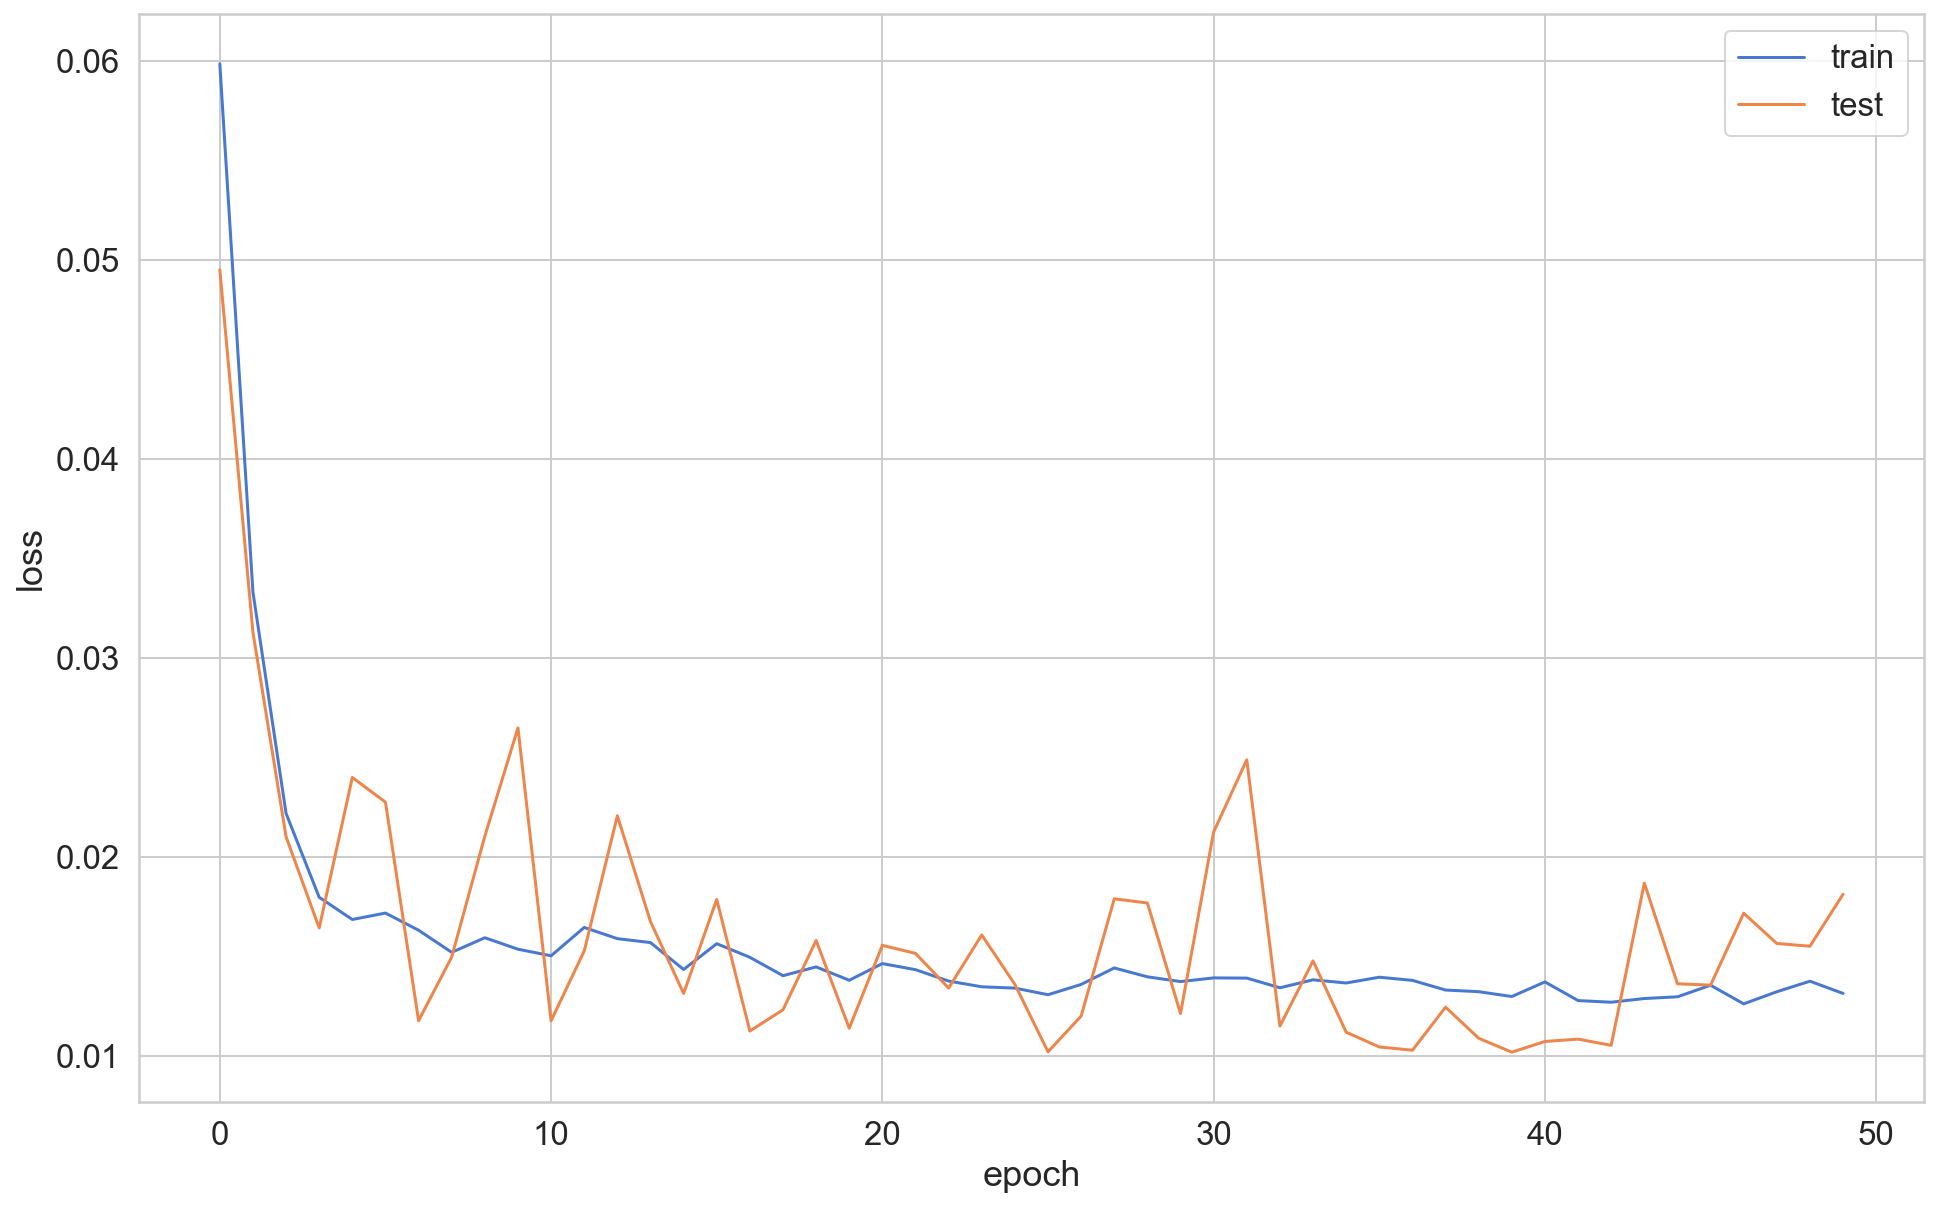

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Prediction 

In [32]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error


With forecasts and actual values in their original scale, we can then calculate an error score for the model. I calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [33]:

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = d_transformer.inverse_transform(trainPredict)
trainY = d_transformer.inverse_transform(y_train.reshape(1,-1))
testPredict = d_transformer.inverse_transform(testPredict)
testY = d_transformer.inverse_transform(y_test.reshape(1,-1))
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY, trainPredict.reshape(1,-1)))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY, testPredict.reshape(1,-1)))
print('Test Score: %.3f RMSE' % (testScore))


Train Score: 0.480 RMSE
Test Score: 0.457 RMSE


In [34]:
y = dataset['duration'].values
#X, y = create_dataset(df, df.duration, time_steps=10)

In [35]:
len(trainPredict)

61694

In [36]:
len(testPredict)

6846

In [37]:
len(trainPredict)+len(testPredict)

68540

In [38]:
len(y)

68560

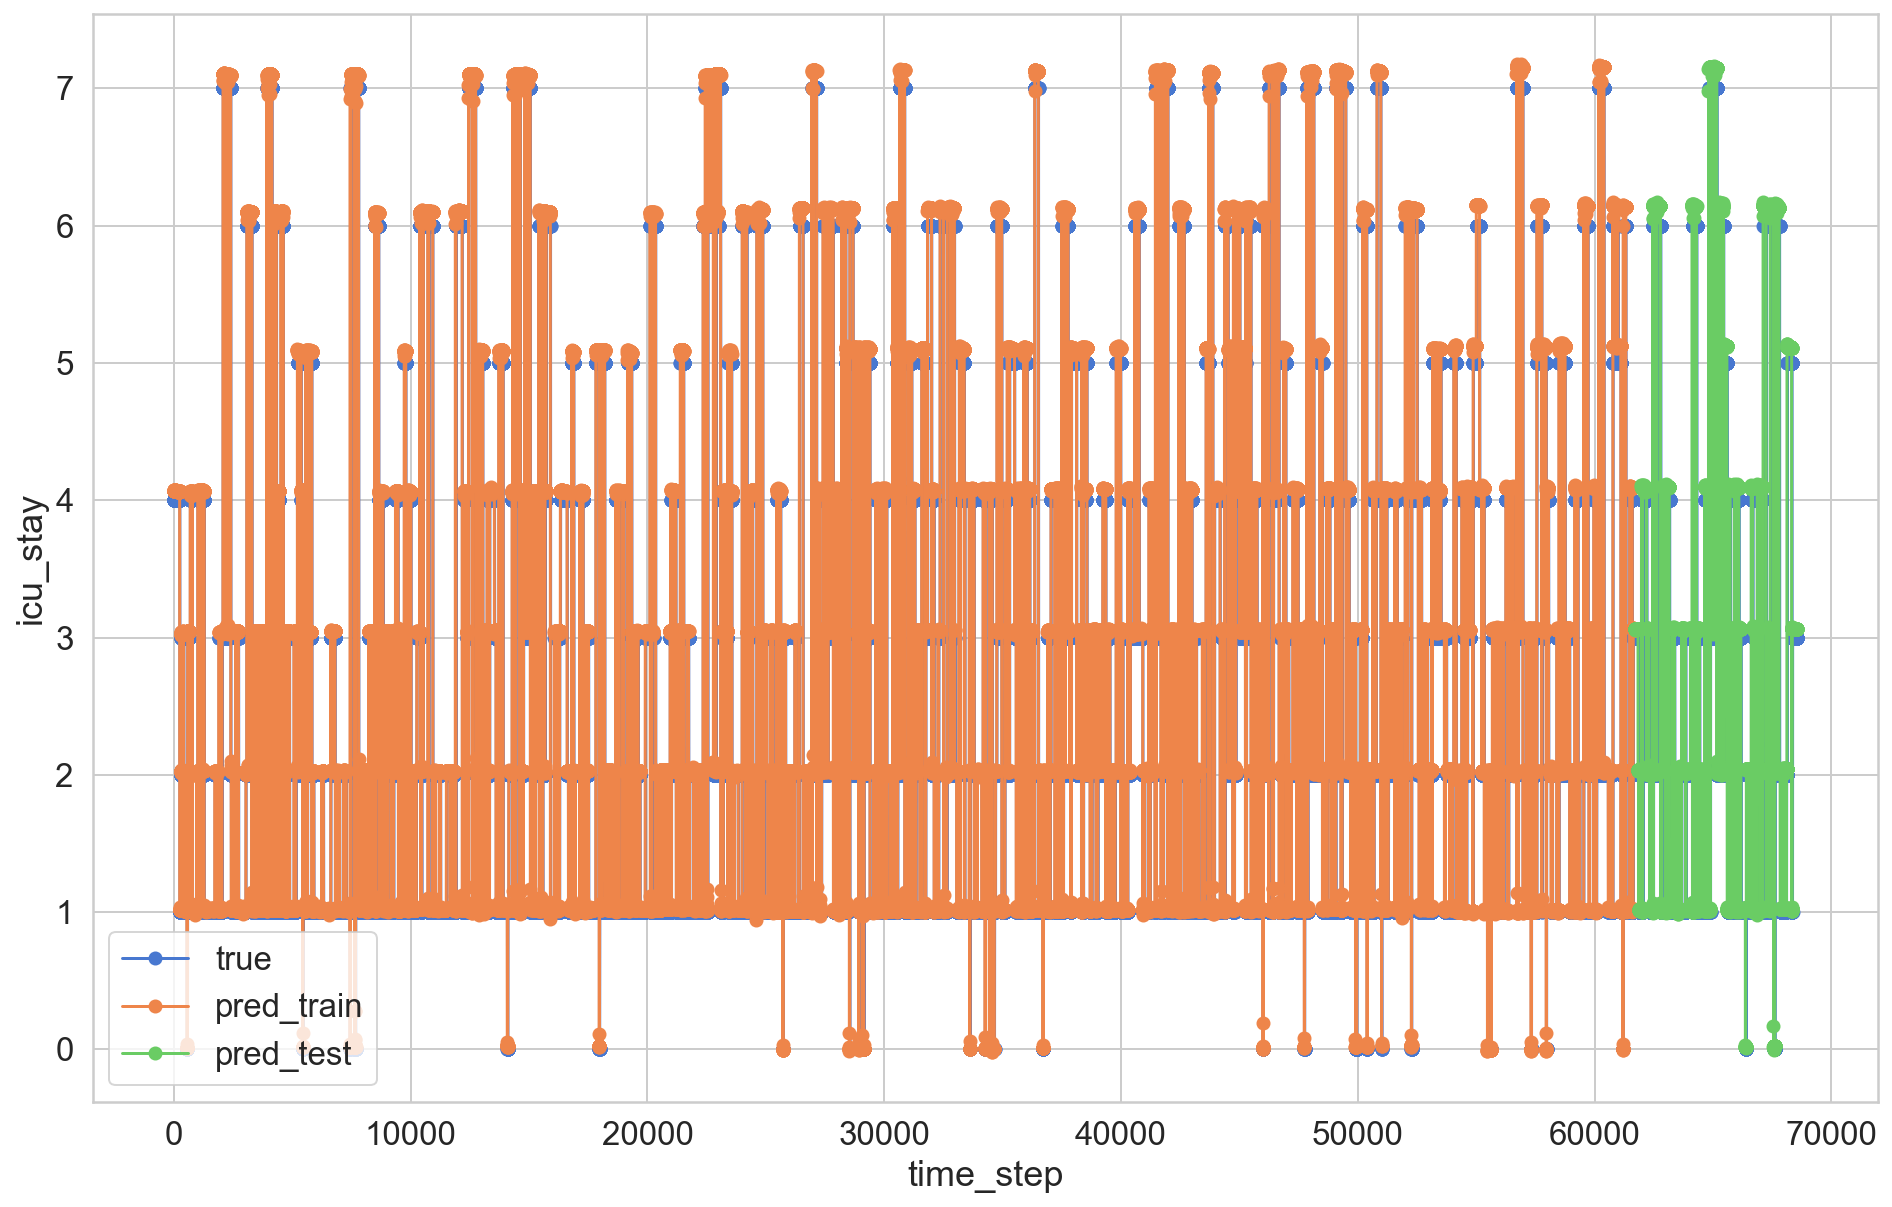

In [39]:
time_steps=10
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:]=np.nan
trainPredictPlot[0:len(trainPredict)] = trainPredict.reshape(1,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict):len(y)-2*time_steps] = testPredict.reshape(1,-1)
# plot baseline and predictions
plt.plot(y.flatten(),marker = 'o',label ='true')
plt.plot(trainPredictPlot,marker = 'o',label ='pred_train')
plt.plot(testPredictPlot,marker = 'o',label ='pred_test')
plt.xlabel('time_step')
plt.ylabel('icu_stay')
plt.legend()
plt.show()

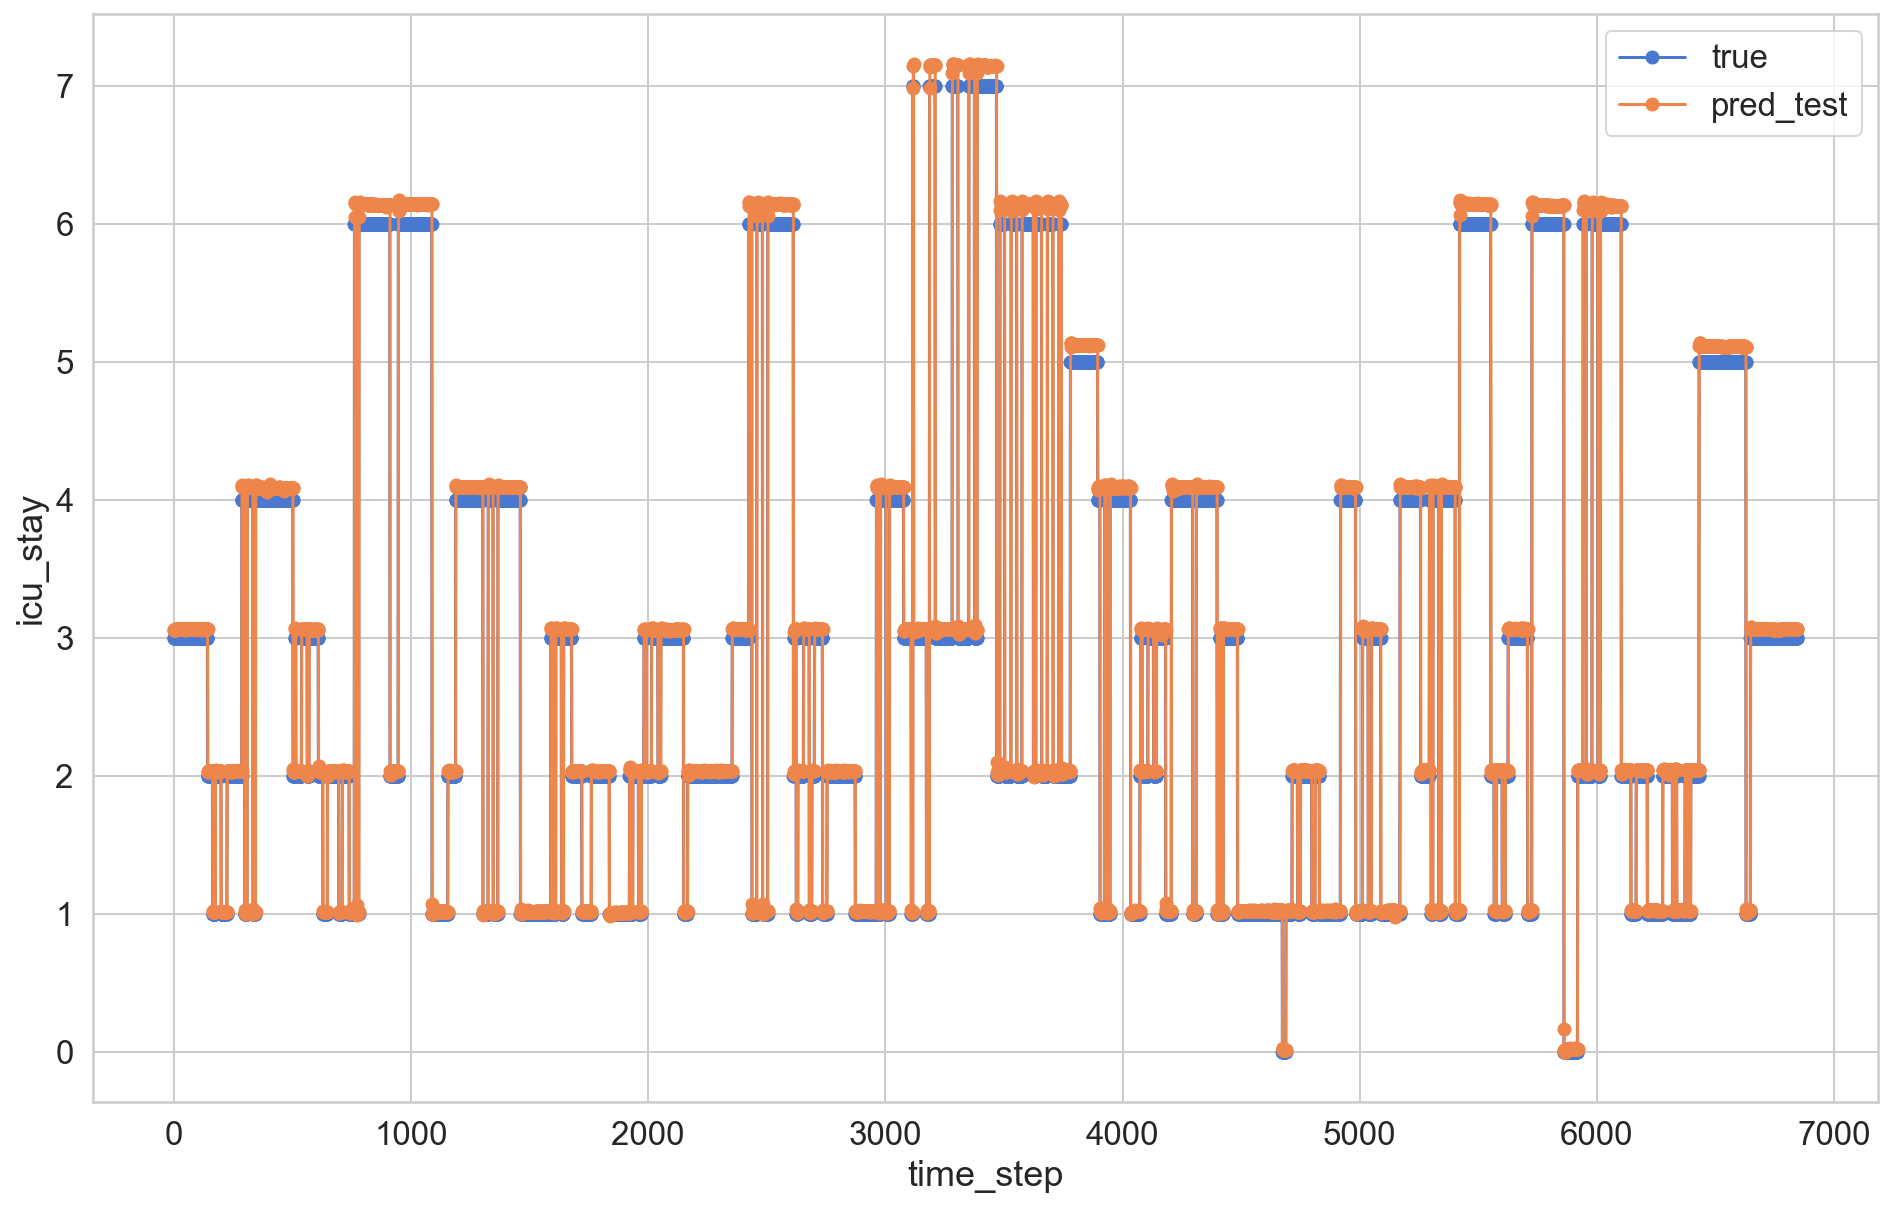

In [40]:
plt.plot(testY.flatten(),marker = 'o',label ='true')
plt.plot(testPredict.flatten(),marker = 'o',label ='pred_test')
plt.xlabel('time_step')
plt.ylabel('icu_stay')
plt.legend()

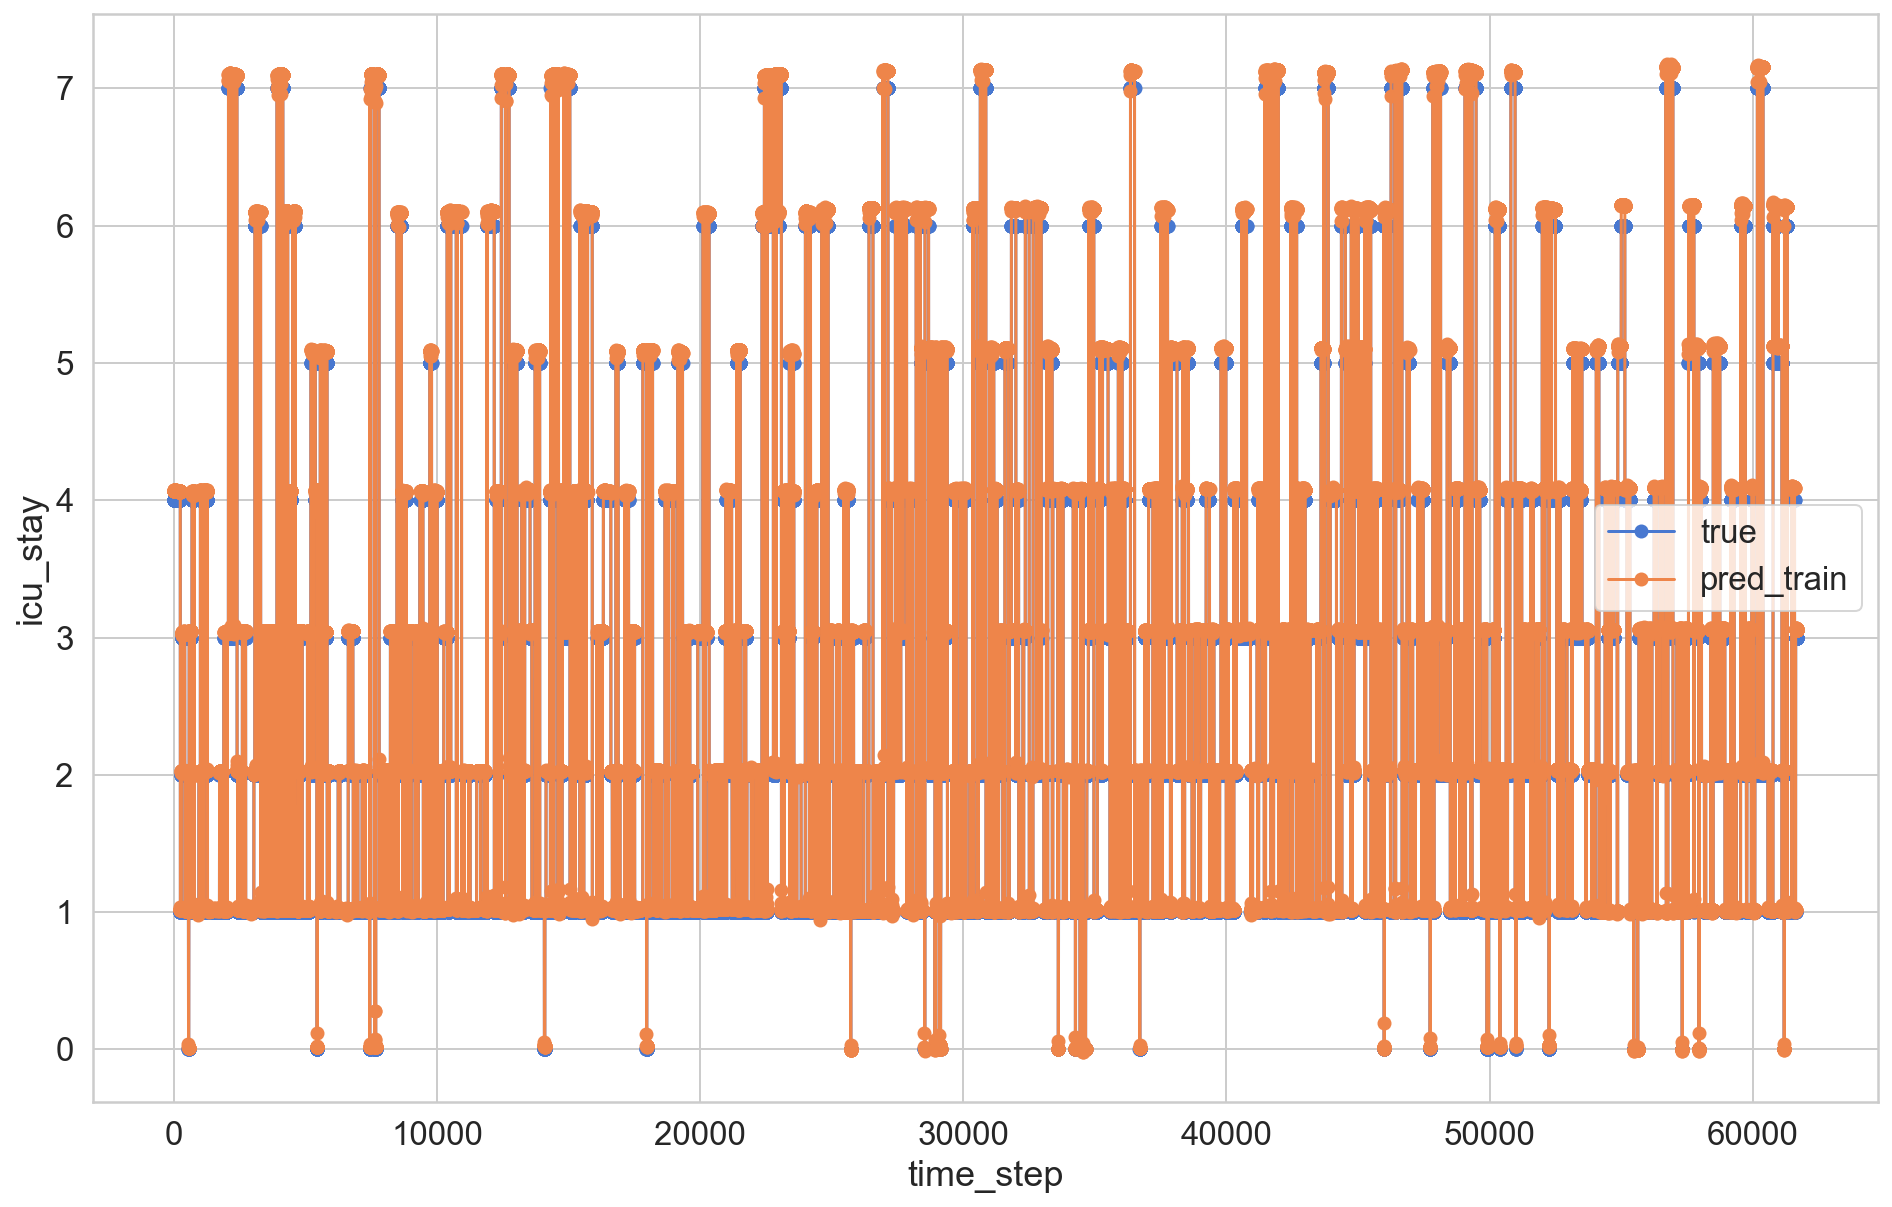

In [41]:
plt.plot(trainY.flatten(),marker = 'o',label ='true')
plt.plot(trainPredict.flatten(),marker = 'o',label ='pred_train')
plt.xlabel('time_step')
plt.ylabel('icu_stay')
plt.legend()

## Conclusion

The deep learning model showed a predictive performance on the testing dataset in which  target is the ICU stay.